<a id='section1'></a>
## Importing data & libraries

In [1]:
agb_data_path = "preprocess/agb_avitabile_2010-2016_v3.nc" #Baseline data

In [2]:
fire_anomalies_data_path = "raw/SEAS_FIRE_ANOMALIES_2010_2018"

In [3]:
import xarray as xr
import numpy
import os
from os import listdir
from os.path import isfile, join, isdir
import matplotlib.pyplot as plt

In [4]:
"""Load AGB data into an xarray dataset"""
agb_data = xr.open_dataset(agb_data_path)

### Loading and Combining all the files present in Fire Anomalies folder

In [5]:
#Function to get all file names
def _get_file_list(root):
    files = [join(root, f) for f in listdir(root) if isfile(join(root, f))]
    dirs = [d for d in listdir(root) if isdir(join(root, d))]
    return files
list_files = sorted(_get_file_list(fire_anomalies_data_path))  #List of data file paths
fire_anomalies_data = xr.open_mfdataset(paths=list_files, parallel=True)

## Before pre-processing

In [6]:
print(fire_anomalies_data)

<xarray.Dataset>
Dimensions:    (latitude: 601, longitude: 1200, time: 108)
Coordinates:
  * latitude   (latitude) float64 90.0 89.7 89.4 89.1 ... -89.4 -89.7 -90.0
  * longitude  (longitude) float64 0.0 0.3 0.6 0.9 ... 358.8 359.1 359.4 359.7
  * time       (time) datetime64[ns] 2010-01-01 2010-02-01 ... 2018-12-01
Data variables:
    fwinx      (time, latitude, longitude) float32 dask.array<chunksize=(1, 601, 1200), meta=np.ndarray>
    ffmcode    (time, latitude, longitude) float32 dask.array<chunksize=(1, 601, 1200), meta=np.ndarray>
    dufmcode   (time, latitude, longitude) float32 dask.array<chunksize=(1, 601, 1200), meta=np.ndarray>
    drtcode    (time, latitude, longitude) float32 dask.array<chunksize=(1, 601, 1200), meta=np.ndarray>
    infsinx    (time, latitude, longitude) float32 dask.array<chunksize=(1, 601, 1200), meta=np.ndarray>
    fbupinx    (time, latitude, longitude) float32 dask.array<chunksize=(1, 601, 1200), meta=np.ndarray>
    fdsrte     (time, latitude, long

In [7]:
print(fire_anomalies_data.to_dataframe().describe())

              fwinx       ffmcode      dufmcode       drtcode       infsinx  \
count  2.020594e+07  2.020594e+07  2.020594e+07  2.020594e+07  2.020594e+07   
mean  -1.623536e-01 -1.223721e-01 -1.713391e+00 -1.016248e+01 -5.738872e-02   
std    2.033462e+00  2.082743e+00  2.241512e+02  3.331530e+02  8.263102e-01   
min   -3.012919e+01 -2.592364e+01 -6.650522e+03 -6.577878e+03 -2.008935e+01   
25%   -5.023918e-01 -1.130508e+00 -1.471191e+00 -3.020361e+01 -2.072312e-01   
50%   -3.152847e-03 -1.405020e-01  0.000000e+00  2.504883e-01 -5.021572e-03   
75%    2.758474e-01  8.531513e-01  1.085938e+00  2.552441e+01  1.434231e-01   
max    3.378488e+01  2.762806e+01  6.899184e+03  6.994597e+03  1.547185e+01   

            fbupinx        fdsrte  
count  2.020594e+07  2.020594e+07  
mean  -2.328180e+00 -1.022200e-01  
std    1.919875e+02  1.692708e+00  
min   -5.511013e+03 -4.008327e+01  
25%   -2.219727e+00 -1.325200e-01  
50%    4.882812e-04  3.814697e-04  
75%    1.615723e+00  7.498264e-02  


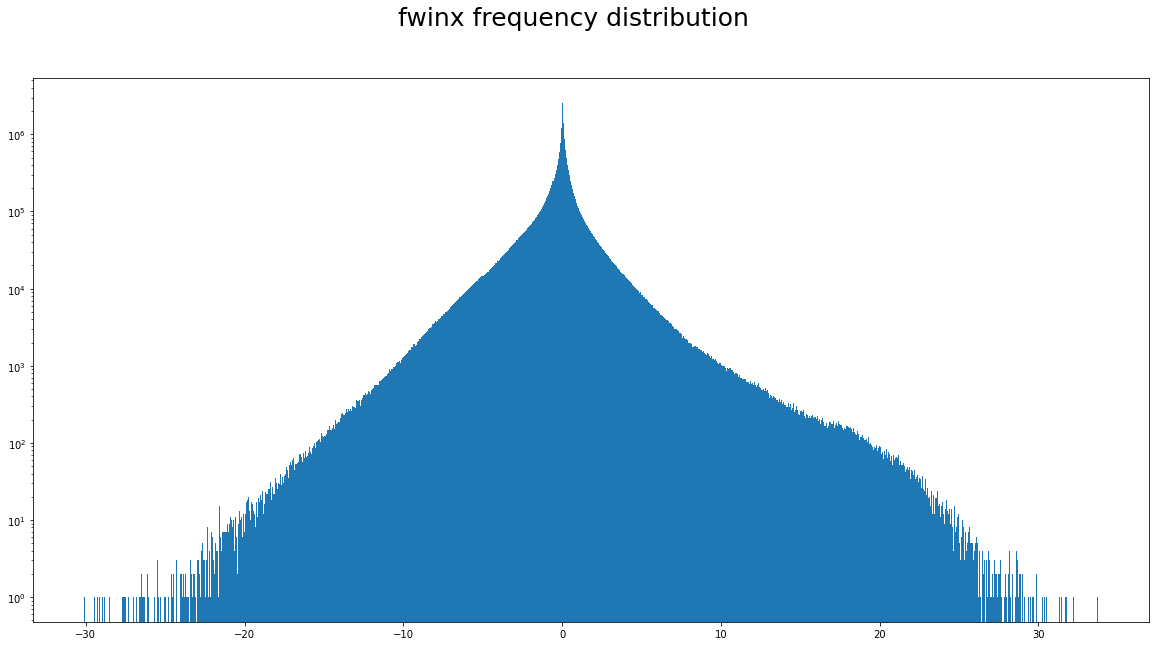

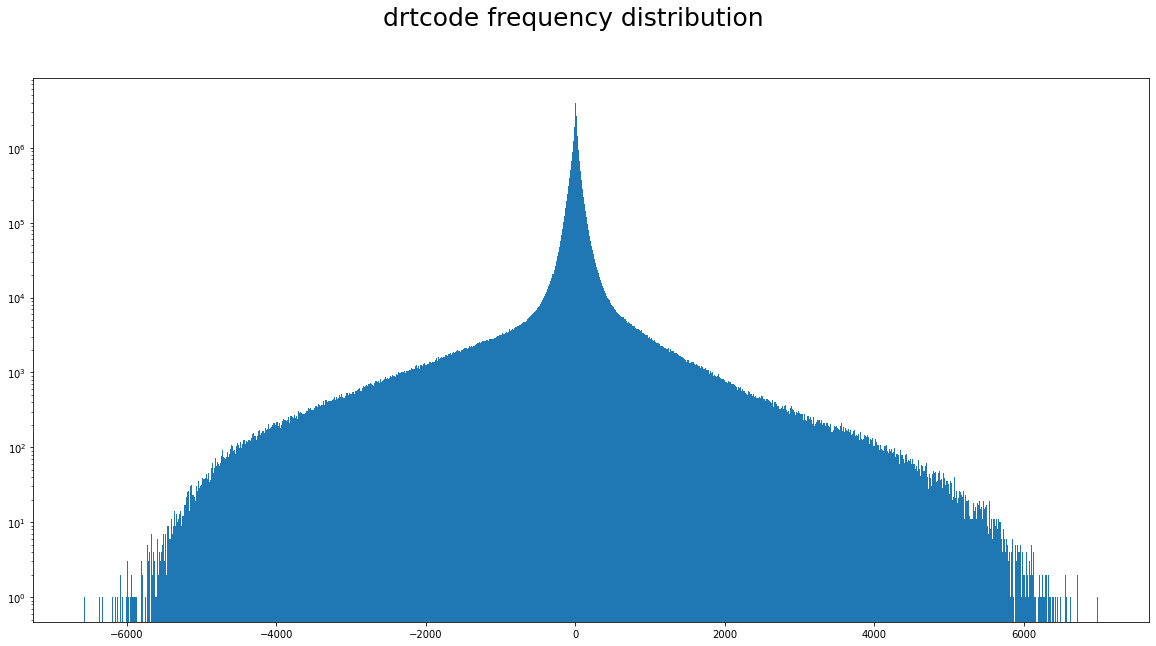

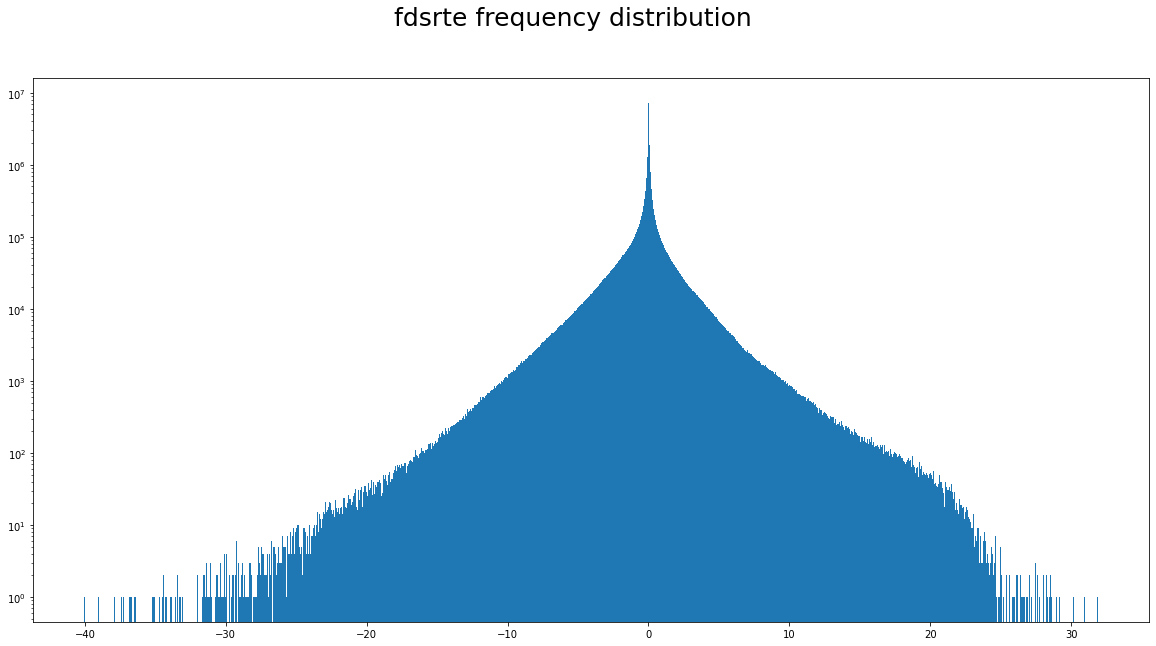

In [8]:
var_list =['fwinx', 'drtcode', 'fdsrte']
for i in range(len(var_list)):
    plt.figure(figsize = (20,10)).suptitle(f'{var_list[i]} frequency distribution', fontsize=25)
    plt.hist(fire_anomalies_data[['fwinx', 'drtcode', 'fdsrte'][i]].values.flatten(), bins=1000, cumulative=False, log=True)

<a id='section2'></a>
## Pre-processing of Slopes

### Droping features that are not required

In [9]:
fire_anomalies_data = fire_anomalies_data.drop(["ffmcode","dufmcode","infsinx","fbupinx"])

### Slicing dataset to take data between years 2010-2016

In [10]:
fire_anomalies_data = fire_anomalies_data.sel(time=slice(fire_anomalies_data.time.values[0], fire_anomalies_data.time.values[83]))

### Interpolating dataset to match resolution of AGB dataset

In [11]:
fire_anomalies_data = fire_anomalies_data.assign_coords({'latitude':fire_anomalies_data.latitude.values,'longitude':xr.where(fire_anomalies_data.longitude > 180, fire_anomalies_data.longitude - 360, fire_anomalies_data.longitude) })

In [12]:
fire_anomalies_data = fire_anomalies_data.interp({'latitude':agb_data.latitude.values,'longitude':agb_data.longitude.values})

### Dataset after pre-processing

In [13]:
print(fire_anomalies_data)

<xarray.Dataset>
Dimensions:    (latitude: 720, longitude: 1440, time: 84)
Coordinates:
  * time       (time) datetime64[ns] 2010-01-01 2010-02-01 ... 2016-12-01
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Data variables:
    fwinx      (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    drtcode    (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    fdsrte     (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2020-12-19T23:50:14

In [14]:
#Pandas describe method
print(fire_anomalies_data.to_dataframe().describe())

              fwinx       drtcode        fdsrte
count  2.135188e+07  2.135188e+07  2.135188e+07
mean  -1.440805e-01 -1.246309e+01 -9.000768e-02
std    2.112835e+00  3.172348e+02  1.759919e+00
min   -2.851545e+01 -5.938001e+03 -3.933221e+01
25%   -5.329489e-01 -3.213037e+01 -1.475618e-01
50%   -4.063242e-03 -1.581421e-01  3.827413e-04
75%    2.943420e-01  2.501126e+01  8.280646e-02
max    3.168857e+01  6.201202e+03  3.051430e+01


### Plots

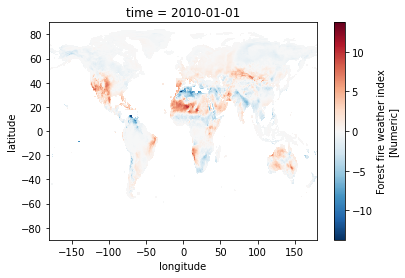

In [15]:
fire_anomalies_data.fwinx[0].plot()

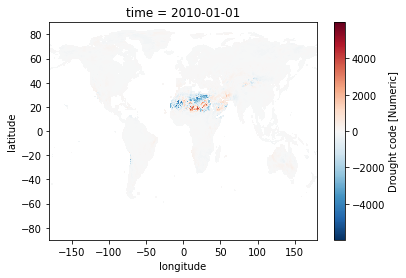

In [16]:
fire_anomalies_data.drtcode[0].plot()

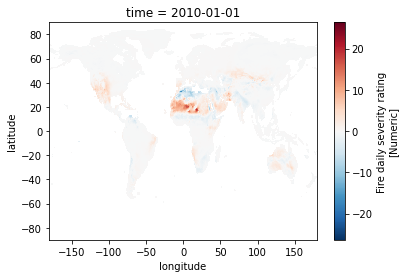

In [17]:
fire_anomalies_data.fdsrte[0].plot()

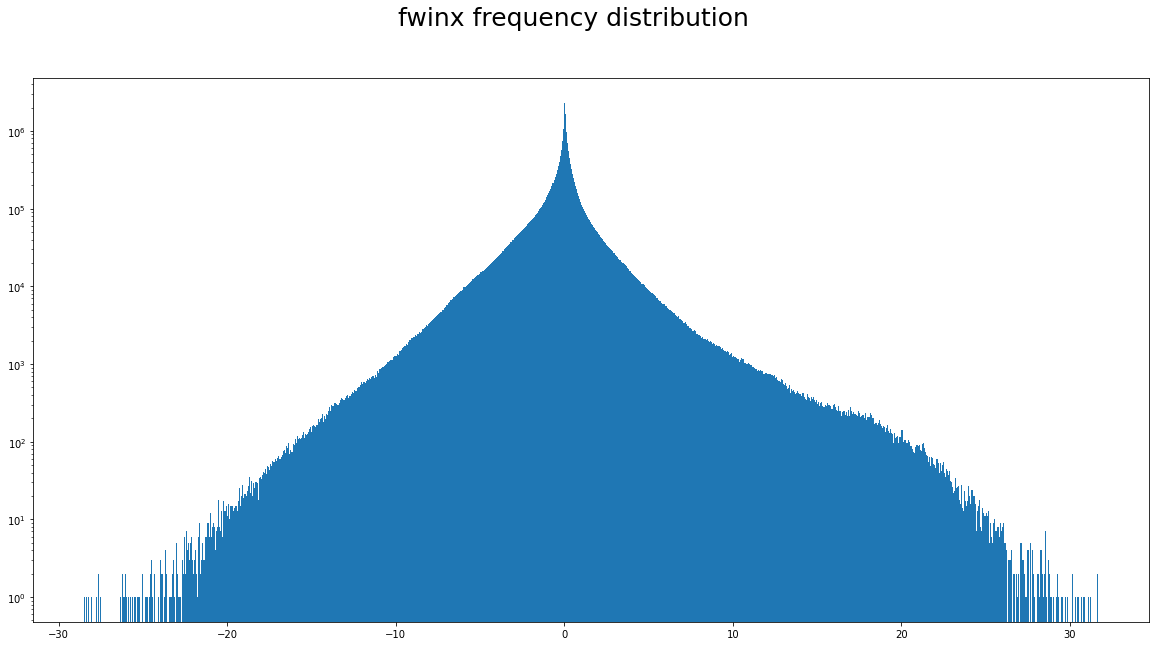

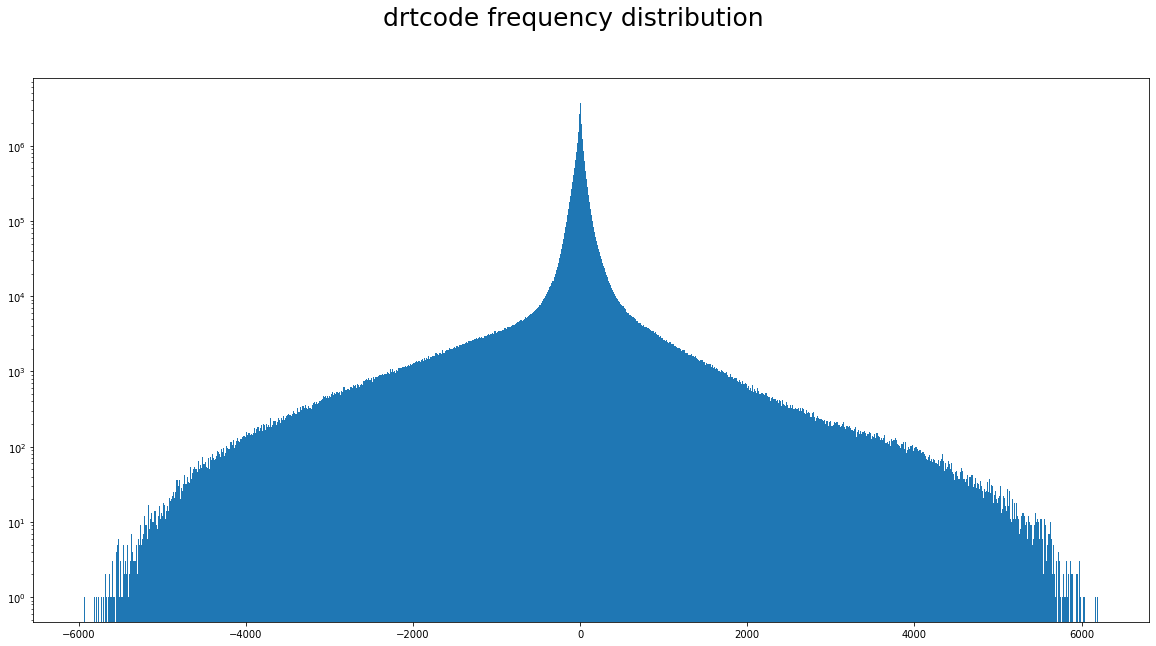

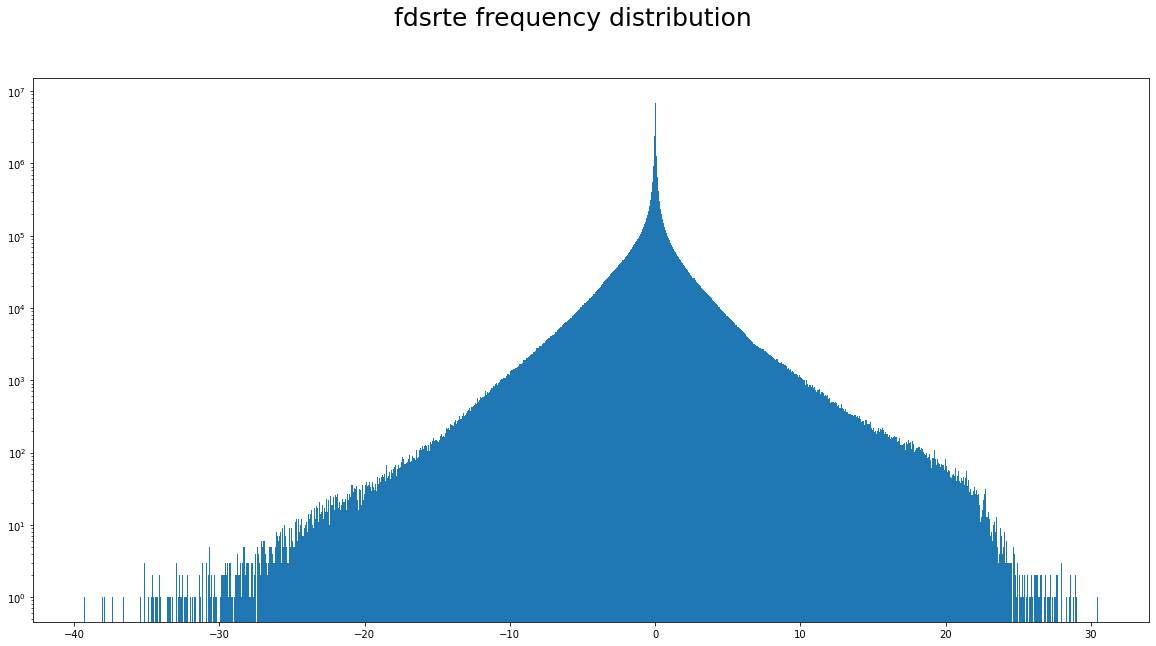

In [18]:
var_list =['fwinx', 'drtcode', 'fdsrte']
for i in range(len(var_list)):
    plt.figure(figsize = (20,10)).suptitle(f'{var_list[i]} frequency distribution', fontsize=25)
    plt.hist(fire_anomalies_data[['fwinx', 'drtcode', 'fdsrte'][i]].values.flatten(), bins=1000, cumulative=False, log=True)

### Saving pre-processed file

In [19]:
fire_anomalies_data.to_netcdf("preprocess/fire_anomalies_2010-2016_v3.nc")

In [20]:
#File size
print(os.stat("preprocess/fire_anomalies_2010-2016_v3.nc").st_size/1e9,"GB")

1.045132541 GB
